In [ ]:
######################################################################################################################

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout


c:\Users\user\Desktop\Data_Science\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
data = pd.read_csv("weatherHistory.csv")


data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)

print(data.head(10))
print(data.isnull().sum())


             Formatted Date        Summary Precip Type  Temperature (C)  \
0 2006-03-31 22:00:00+00:00  Partly Cloudy        rain         9.472222   
1 2006-03-31 23:00:00+00:00  Partly Cloudy        rain         9.355556   
2 2006-04-01 00:00:00+00:00  Mostly Cloudy        rain         9.377778   
3 2006-04-01 01:00:00+00:00  Partly Cloudy        rain         8.288889   
4 2006-04-01 02:00:00+00:00  Mostly Cloudy        rain         8.755556   
5 2006-04-01 03:00:00+00:00  Partly Cloudy        rain         9.222222   
6 2006-04-01 04:00:00+00:00  Partly Cloudy        rain         7.733333   
7 2006-04-01 05:00:00+00:00  Partly Cloudy        rain         8.772222   
8 2006-04-01 06:00:00+00:00  Partly Cloudy        rain        10.822222   
9 2006-04-01 07:00:00+00:00  Partly Cloudy        rain        13.772222   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.26

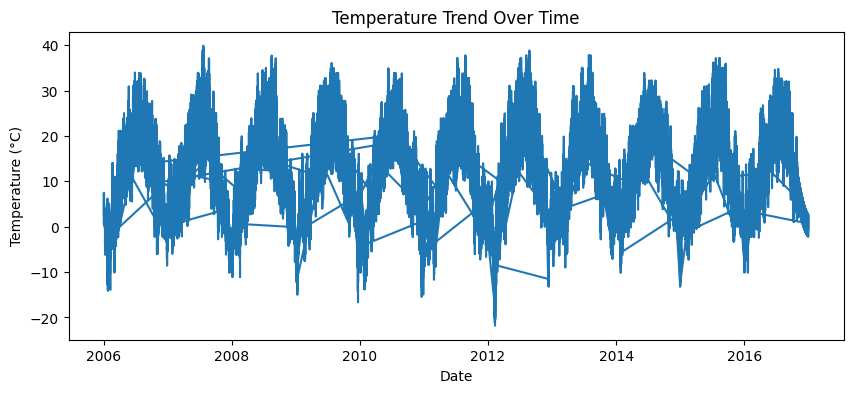

In [ ]:
# Temperature trend plot
plt.figure(figsize=(10,4))
plt.plot(data['Formatted Date'], data['Temperature (C)'])
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trend Over Time")
plt.show()


In [ ]:
# Hourly → Daily data conversion
data.set_index('Formatted Date', inplace=True)

# taken only numeric columns mean 
daily_data = data.select_dtypes(include='number').resample('D').mean()
daily_data.reset_index(inplace=True)

print(daily_data.head())


             Formatted Date  Temperature (C)  Apparent Temperature (C)  \
0 2005-12-31 00:00:00+00:00         0.577778                 -4.050000   
1 2006-01-01 00:00:00+00:00         4.075000                 -0.174537   
2 2006-01-02 00:00:00+00:00         5.263194                  1.808796   
3 2006-01-03 00:00:00+00:00         2.340509                  0.445370   
4 2006-01-04 00:00:00+00:00         2.251852                 -0.663194   

   Humidity  Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
0  0.890000          17.114300              140.000000         9.982000   
1  0.817083          21.229192              142.750000        11.348487   
2  0.847083          17.824713              164.583333         8.492079   
3  0.897083           7.726658              252.541667         9.223958   
4  0.906667          12.152817               35.000000         8.352546   

   Loud Cover  Pressure (millibars)  
0         0.0           1016.660000  
1         0.0           1011

In [38]:
# feature selection
features = [
    'Temperature (C)',
    'Humidity',
    'Wind Speed (km/h)',
    'Pressure (millibars)'
]

daily_data = daily_data[features]


In [39]:
# Normalization (MinMaxScaler)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data)


In [40]:
# Sequence creation (Past 7 days → Next day)
def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 0])  # Temperature
    return np.array(X), np.array(y)

SEQ_LEN = 7
X, y = create_sequences(scaled_data, SEQ_LEN)

print(X.shape, y.shape)


(4012, 7, 4) (4012,)


In [41]:
# Train / Validation / Test split
train_size = int(0.7 * len(X))
val_size   = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]


In [42]:
# Build SimpleRNN Model
model = Sequential([
    SimpleRNN(64, input_shape=(SEQ_LEN, X.shape[2]), activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()


c:\Users\user\Desktop\Data_Science\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0646 - mae: 0.1878 - val_loss: 0.0075 - val_mae: 0.0703
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0149 - mae: 0.0969 - val_loss: 0.0035 - val_mae: 0.0467
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0113 - mae: 0.0842 - val_loss: 0.0034 - val_mae: 0.0453
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0092 - mae: 0.0763 - val_loss: 0.0027 - val_mae: 0.0410
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0084 - mae: 0.0730 - val_loss: 0.0025 - val_mae: 0.0393
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0076 - mae: 0.0689 - val_loss: 0.0023 - val_mae: 0.0377
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0072 - mae: 0.0671 - val_loss: 0.0032 - val_mae: 0.0453
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0069 - mae: 0.0653 - val_loss: 0.0047 - val_mae: 0.0576
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.006

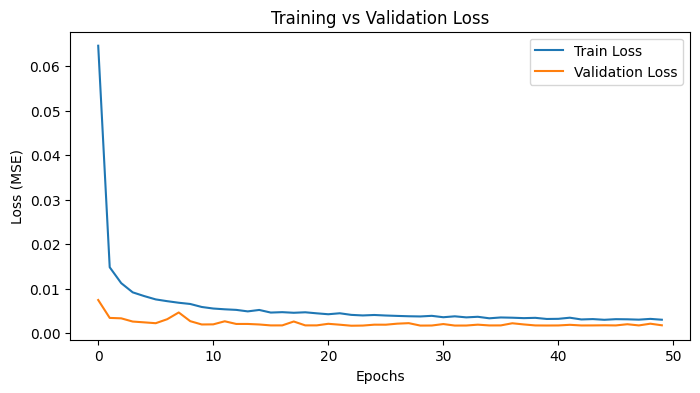

In [44]:
# Training vs Validation Loss plot
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [45]:
# Model evaluation on Test set
y_pred = model.predict(X_test)

# Inverse scaling (Temperature column only)
temp_scaler = MinMaxScaler()
temp_scaler.min_, temp_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

y_test_inv = (y_test - temp_scaler.min_) / temp_scaler.scale_
y_pred_inv = (y_pred.flatten() - temp_scaler.min_) / temp_scaler.scale_

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
MAE : 1.4523108488715315
RMSE: 1.9419079914148436
R2  : 0.9472748588523952


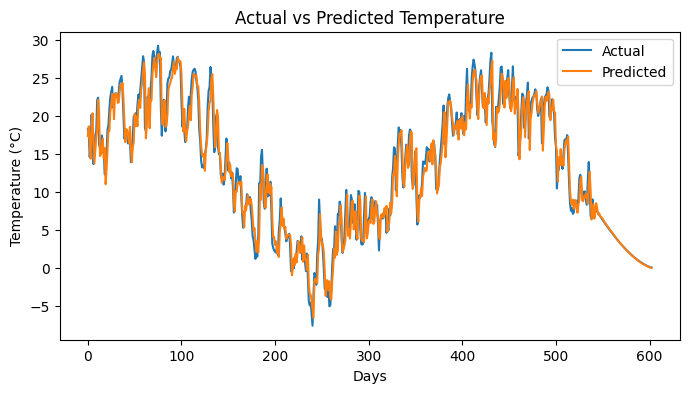

In [46]:
# Actual vs Predicted Temperature plot
plt.figure(figsize=(8,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Predicted Temperature")
plt.legend()
plt.show()


In [47]:
# Forecast next 7 days
last_sequence = X[-1]
future_preds = []

current_seq = last_sequence.copy()

for _ in range(7):
    pred = model.predict(current_seq.reshape(1, SEQ_LEN, X.shape[2]))
    future_preds.append(pred[0,0])
    
    current_seq = np.roll(current_seq, -1, axis=0)
    current_seq[-1, 0] = pred  # temperature update

# Inverse scale
future_preds_inv = (np.array(future_preds) - temp_scaler.min_) / temp_scaler.scale_

print("Next 7 days temperature prediction:")
print(future_preds_inv)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

C:\Users\user\AppData\Local\Temp\ipykernel_19148\2394250342.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1, 0] = pred  # temperature update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Next 7 days temperature prediction:
[ 0.03593684 -0.06103737 -0.15355651 -0.23721712 -0.30991013 -0.37744136
 -0.4287066 ]


In [ ]:
# Final corrected forecasting loop (FULL)

In [49]:
last_sequence = X[-1]
future_preds = []

current_seq = last_sequence.copy()

for _ in range(7):
    pred = model.predict(current_seq.reshape(1, SEQ_LEN, X.shape[2]))
    future_preds.append(pred[0,0])

    current_seq = np.roll(current_seq, -1, axis=0)
    current_seq[-1, 0] = pred[0,0]   # FIXED


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


In [ ]:
# Convert these to original Temperature (°C)

In [51]:
future_preds = np.array(future_preds).reshape(-1, 1)


In [52]:
future_preds_original = temp_scaler.inverse_transform(future_preds)

print("Next 7 days temperature prediction (°C):")
print(future_preds_original.flatten())


Next 7 days temperature prediction (°C):
[ 0.03593684 -0.06103737 -0.15355651 -0.23721711 -0.30991012 -0.37744138
 -0.42870662]


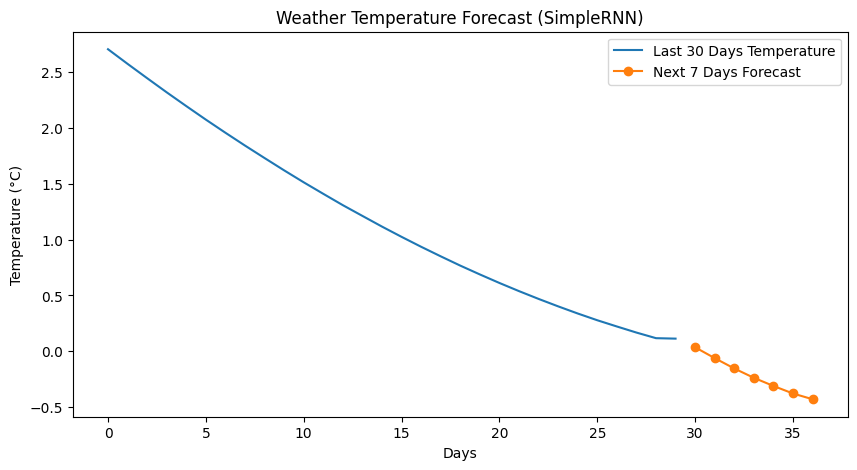

In [53]:
last_30_days = daily_data['Temperature (C)'].values[-30:]

plt.figure(figsize=(10,5))
plt.plot(range(30), last_30_days, label="Last 30 Days Temperature")
plt.plot(range(30, 37), future_preds_original.flatten(), 
         label="Next 7 Days Forecast", marker='o')

plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.title("Weather Temperature Forecast (SimpleRNN)")
plt.legend()
plt.show()
